### Buil A Basic Chatbot With Langgraph(GRAPH API)


In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

c:\Users\LENOVO\Desktop\AI_Projects\MCP_krish\.venv\Lib\site-packages\langchain_core\_api\deprecation.py:26: UserWarning: Core Pydantic V1 functionality isn't compatible with Python 3.14 or greater.
  from pydantic.v1.fields import FieldInfo as FieldInfoV1


In [2]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages:Annotated[list,add_messages]

In [3]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
from langchain_openai import ChatOpenAI
llm=ChatOpenAI(model="gpt-4o-mini")

In [5]:
llm

ChatOpenAI(profile={'max_input_tokens': 128000, 'max_output_tokens': 16384, 'image_inputs': True, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True, 'structured_output': True, 'image_url_inputs': True, 'pdf_inputs': True, 'pdf_tool_message': True, 'image_tool_message': True, 'tool_choice': True}, client=<openai.resources.chat.completions.completions.Completions object at 0x0000021B6670B0E0>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x0000021B6670BB60>, root_client=<openai.OpenAI object at 0x0000021B6616D550>, root_async_client=<openai.AsyncOpenAI object at 0x0000021B6670B8C0>, model_name='gpt-4o-mini', model_kwargs={}, openai_api_key=SecretStr('**********'), stream_usage=True)

In [6]:
## Node Functionality
def chatbot(state:State)->State:
    return {"messages":[llm.invoke(state["messages"])]}

In [7]:
graph_builder=StateGraph(State)
## Adding node
graph_builder.add_node("llmchatbot",chatbot)
## Adding edges
graph_builder.add_edge(START, "llmchatbot")
graph_builder.add_edge("llmchatbot", END)

# compile the graph
graph=graph_builder.compile()

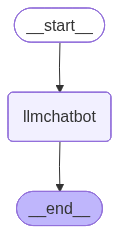

In [8]:
## Visualize the graph
from IPython.display import Image,display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [9]:
response=graph.invoke({"messages":"Hello,who is the PM of India?"})


In [10]:
response["messages"][-1].content

'As of my last update in October 2023, the Prime Minister of India is Narendra Modi. He has been in office since May 2014. Please verify with current sources for the latest information.'

In [11]:
for event in graph.stream({"messages":"Hi,how are you?"}):
    for value in event.values():
        print(value["messages"][-1].content)

Hello! I'm just a program, but I'm here and ready to help you. How can I assist you today?


### Using tools with the ChatBot

In [6]:
from langchain_tavily import TavilySearch

tool=TavilySearch(max_results=2)
tool.invoke("What is the capital of India?")


{'query': 'What is the capital of India?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.usatoday.com/story/news/world/2023/05/24/what-is-the-capital-of-india/70195720007/',
   'title': 'What is the capital of India? States and union territories ...',
   'content': 'The capital of India is New Delhi, located in the north-central part of the country to the west of the Yamuna River.',
   'score': 0.999826,
   'raw_content': None},
  {'url': 'https://www.countryreports.org/country/India/capital-city.htm',
   'title': 'Capital City of India',
   'content': '# What is the Capital of India? ## Capital City Map of India',
   'score': 0.99586606,
   'raw_content': None}],
 'response_time': 0.0,
 'request_id': 'adbfcc95-cf2c-4b53-a867-f38770b070e5'}

In [7]:
## Custom Tool
def multiply(a:int,b:int)->int:
    """Multiply a and b
    Args:
        a: int
        b: int
    Returns:
        int: The product of a and b
    """
    return a*b

In [8]:
tools=[tool,multiply]

In [9]:
## Binding the tools to the model
llm_with_tools=llm.bind_tools(tools)

In [10]:
llm_with_tools


RunnableBinding(bound=ChatOpenAI(profile={'max_input_tokens': 128000, 'max_output_tokens': 16384, 'image_inputs': True, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True, 'structured_output': True, 'image_url_inputs': True, 'pdf_inputs': True, 'pdf_tool_message': True, 'image_tool_message': True, 'tool_choice': True}, client=<openai.resources.chat.completions.completions.Completions object at 0x0000021B6670B0E0>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x0000021B6670BB60>, root_client=<openai.OpenAI object at 0x0000021B6616D550>, root_async_client=<openai.AsyncOpenAI object at 0x0000021B6670B8C0>, model_name='gpt-4o-mini', model_kwargs={}, openai_api_key=SecretStr('**********'), stream_usage=True), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for compre

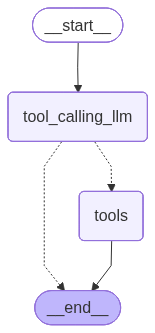

In [12]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node definition
def tool_calling_llm(state:State)->State:
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

## Graph
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add edges
builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools",END)

## compile the graph
graph=builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
response=graph.invoke({"messages":"What is the recent ai news"})


In [14]:
response['messages'][-1].content


'{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://ts2.tech/en/ai-news-today-december-5-2025-gemini-3-deep-think-anthropics-agentic-ai-and-fresh-security-warnings/", "title": "AI News Today, December 5, 2025: Gemini 3 Deep Think, Anthropic’s Agentic AI, and Fresh Security Warnings - ts2.tech", "score": 0.99963737, "published_date": "Fri, 05 Dec 2025 11:15:01 GMT", "content": "# AI News Today, December 5, 2025: Gemini 3 Deep Think, Anthropic’s Agentic AI, and Fresh Security Warnings. From Google’s new Gemini 3 Deep Think mode to Anthropic’s $200 million “agentic AI” deal with Snowflake, and new guidance from security agencies on how\xa0*not*\xa0to use AI in critical infrastructure, today’s headlines show an industry that’s both accelerating and learning to hit the brakes. Together with infrastructure deals like NEXTDC and product tweaks like ChatGPT Atlas AI, today’s announcements reinforce OpenAI’s strategy:\xa0**embed i

In [15]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the recent ai news
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_xxJFjQTb0xHPhw9MgeFLHuRw)
 Call ID: call_xxJFjQTb0xHPhw9MgeFLHuRw
  Args:
    query: recent AI news
    topic: news
    time_range: week
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://ts2.tech/en/ai-news-today-december-5-2025-gemini-3-deep-think-anthropics-agentic-ai-and-fresh-security-warnings/", "title": "AI News Today, December 5, 2025: Gemini 3 Deep Think, Anthropic’s Agentic AI, and Fresh Security Warnings - ts2.tech", "score": 0.99963737, "published_date": "Fri, 05 Dec 2025 11:15:01 GMT", "content": "# AI News Today, December 5, 2025: Gemini 3 Deep Think, Anthropic’s Agentic AI, and Fresh Sec

In [16]:
response=graph.invoke({"messages":"What is 5 multiplied by 2"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 5 multiplied by 2
================================== Ai Message ==================================
Tool Calls:
  multiply (call_puMJDOfYP7aZBTcK20BcsTmF)
 Call ID: call_puMJDOfYP7aZBTcK20BcsTmF
  Args:
    a: 5
    b: 2
================================= Tool Message =================================
Name: multiply

10


In [17]:
response=graph.invoke({"messages":"Give me the recent ai news and then multiply 5 by 10"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Give me the recent ai news and then multiply 5 by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_bLdbI3WbhgBAMxGyOF3E7kRK)
 Call ID: call_bLdbI3WbhgBAMxGyOF3E7kRK
  Args:
    query: recent AI news
    topic: news
    time_range: week
  multiply (call_kQtWljZaCyeBcSuSRpAVgoCU)
 Call ID: call_kQtWljZaCyeBcSuSRpAVgoCU
  Args:
    a: 5
    b: 10
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://ts2.tech/en/ai-news-today-december-5-2025-gemini-3-deep-think-anthropics-agentic-ai-and-fresh-security-warnings/", "title": "AI News Today, December 5, 2025: Gemini 3 Deep Think, Anthropic’s Agentic AI, and Fresh Security Warnings - ts2.tech", "score": 0.8095324, "published_date": "Fr

### ReAct Agent Architecture

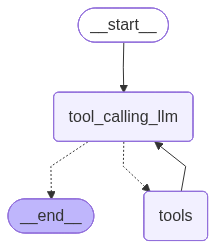

In [18]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node definition
def tool_calling_llm(state:State)->State:
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

## Graph
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add edges
builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")

## compile the graph
graph=builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
response=graph.invoke({"messages":"Give me the recent ai news and then multiply 5 by 10"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Give me the recent ai news and then multiply 5 by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_J70hByYBeEnVWgdBYgccKCXJ)
 Call ID: call_J70hByYBeEnVWgdBYgccKCXJ
  Args:
    query: AI news
    topic: news
    time_range: week
  multiply (call_L6nXWCG5CXOgLjzPOsQQ1T5o)
 Call ID: call_L6nXWCG5CXOgLjzPOsQQ1T5o
  Args:
    a: 5
    b: 10
================================= Tool Message =================================
Name: tavily_search

{"query": "AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.startupecosystem.ca/news/rapidai-and-aws-partner-to-scale-clinical-ai-globally/", "title": "RapidAI and AWS Partner to Scale Clinical AI Globally - Startup Ecosystem Canada", "score": 0.507251, "published_date": "Thu, 04 Dec 2025 00:13:56 GMT", "content": "## RapidAI and AWS Partner to Scale Cl